In [ ]:
import pandas as pd

df = pd.read_csv('data/stock/UNIP3.SA.csv')

df = df[['Date', 'Close']]

import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

df['Date'] = df['Date'].apply(str_to_datetime)

df.index = df.pop('Date')

import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])
import numpy as np
# a variavel clse vai ser o consumo !!!!!!!!!!
window_size = 1 # quantos dias anteriores serão usados para prever o próximo dia
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], [] # variaveis independentes X  e dependentes Y
#
  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy() # vai ser o consumo
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=window_size)
windowed_df
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=window_size)
dates, X, y = windowed_df_to_date_X_y(windowed_df)
model = Sequential([layers.Input((window_size, 1)),
                    layers.LSTM(70),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=65)
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-19,3.290000,3.290000,2.530773,2.530773,1.025119,0.0
1,2000-01-20,3.290000,3.290000,2.530773,2.530773,1.025119,0.0
2,2000-01-21,3.290000,3.290000,2.733273,2.733273,1.107144,0.0
3,2000-01-24,3.290000,3.290000,2.530773,2.530773,1.025119,0.0
4,2000-01-25,2.530773,2.530773,2.530773,2.530773,1.025119,0.0
...,...,...,...,...,...,...,...
5812,2023-03-08,75.000000,75.980003,74.699997,75.599998,75.599998,10500.0
5813,2023-03-09,75.500000,75.610001,75.059998,75.199997,75.199997,8800.0
5814,2023-03-10,75.199997,75.330002,73.500000,74.510002,74.510002,25600.0
5815,2023-03-13,74.510002,74.510002,72.519997,73.000000,73.000000,26700.0


1/1 [==============================] - 0s 67ms/step


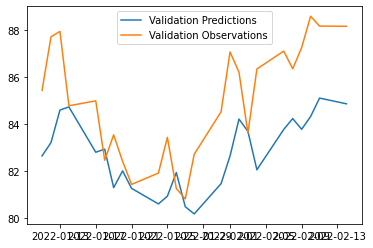

In [14]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 59ms/step


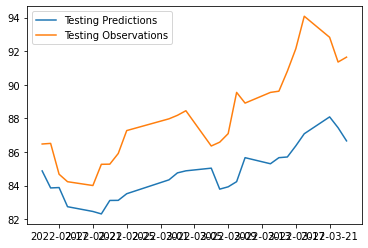

In [15]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

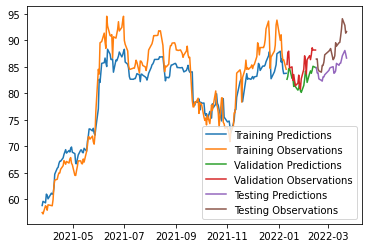

In [17]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [18]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 112ms/step


array([[[56.80909 ]],

       [[57.53636 ]],

       [[57.272728]],

       [[58.81818 ]],

       [[58.627274]],

       [[57.97273 ]],

       [[58.99091 ]],

       [[58.845455]],

       [[58.80909 ]],

       [[59.954544]],

       [[62.5     ]],

       [[63.636364]],

       [[63.80909 ]],

       [[64.545456]],

       [[65.      ]],

       [[65.      ]],

       [[65.681816]],

       [[66.36363 ]],

       [[67.34545 ]],

       [[66.63636 ]],

       [[67.163635]],

       [[66.86363 ]],

       [[67.61818 ]],

       [[67.89091 ]],

       [[66.818184]],

       [[66.527275]],

       [[64.545456]],

       [[64.527275]],

       [[65.454544]],

       [[66.25455 ]],

       [[67.27273 ]],

       [[67.27273 ]],

       [[66.77273 ]],

       [[66.70909 ]],

       [[67.62727 ]],

       [[67.045456]],

       [[69.06364 ]],

       [[70.163635]],

       [[71.80909 ]],

       [[71.79091 ]],

       [[71.36363 ]],

       [[71.94546 ]],

       [[70.87273 ]],

       [[70

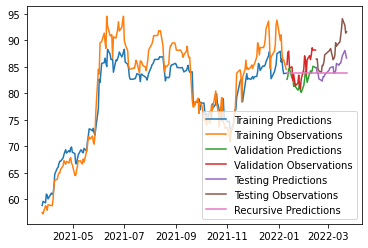

In [19]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])

In [20]:
import plotly.express as px
df_fig = pd.DataFrame({'pred':test_predictions,'real':y_test})
df_fig.index = dates_test

fig = px.line(df_fig,x=df_fig.index,y=['pred','real'])
fig.show()

In [190]:
df_fig

,pred,real
2022-02-15,28.225185,26.400000
2022-02-16,26.581497,26.510000
2022-02-17,26.717655,24.959999
2022-02-18,24.781639,24.639999
2022-02-21,24.377808,24.740000
2022-02-22,24.504135,24.910000
2022-02-23,24.718624,23.700001
2022-02-24,23.185137,23.500000
2022-02-25,22.930334,25.100000
2022-03-02,24.957920,27.129999


# Production

In [ ]:
model.predict(np.array([[[74.11]],[[75.1]],[[66]]])) #prod structure



1/1 [==============================] - 0s 68ms/step


array([[75.183136],
       [75.966934],
       [68.1463  ]], dtype=float32)

In [2]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
# Buscar preços reais
import plotly.graph_objects as go


# Função para converter string em datetime
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)


# Função para criar janelas de dados
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n):
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    target_date = first_date
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n + 1)

        if len(df_subset) != n + 1:
            print(f'Erro: Janela de tamanho {n} é muito grande para a data {target_date}')
            return None

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date + datetime.timedelta(days=7)]
        if len(next_week) < 2:
            break

        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year, month, day = map(int, next_date_str.split('-'))
        next_date = datetime.datetime(year=year, month=month, day=day)

        if last_time:
            break

        target_date = next_date
        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(n):
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

def adjust_dates_to_available(df, start_date, end_date):
    if start_date not in df.index:
        start_date = df.index[df.index.get_indexer([start_date], method='nearest')[0]]
        print(f'Data inicial ajustada para {start_date}')

    if end_date not in df.index:
        end_date = df.index[df.index.get_indexer([end_date], method='nearest')[0]]
        print(f'Data final ajustada para {end_date}')
    
    return start_date, end_date

# Função para converter janela para entrada do modelo
def windowed_df_to_date_X_y(windowed_dataframe):
    if windowed_dataframe is None or windowed_dataframe.empty:
        raise ValueError("O DataFrame de janela está vazio ou é None. Verifique as entradas.")

    df_as_np = windowed_dataframe.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)


# Treinamento do modelo
def train_model(ticker, start_date, end_date, window_size):
    df = yf.Ticker(ticker).history(period='max')
    df = df[['Close']]
    
    # Garantir que o índice seja datetime sem timezone e sem hora
    df.index = pd.to_datetime(df.index).tz_convert(None).normalize()

    # Garantir que start_date e end_date também estejam normalizadas
    start_date = pd.to_datetime(start_date).normalize()
    end_date = pd.to_datetime(end_date).normalize()

    start_date, end_date = adjust_dates_to_available(df, start_date, end_date)

    windowed_df = df_to_windowed_df(df, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'), n=window_size)

    if windowed_df is None or windowed_df.empty:
        raise ValueError("Erro: df_to_windowed_df retornou um DataFrame vazio ou None.")

    dates, X, y = windowed_df_to_date_X_y(windowed_df)

    q_80 = int(len(dates) * .8)
    q_90 = int(len(dates) * .9)

    dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
    dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
    dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

    model = Sequential([
        layers.Input((window_size, 1)),
        layers.LSTM(70),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mse',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=65)

    return model, dates_test, X_test


# Parâmetros do modelo
ticker = 'KEPL3.SA'
start_date = '2024-01-08'
end_date = '2024-11-29'
window_size = 5

# Treinamento do modelo
model, dates_test, X_test = train_model(ticker, start_date, end_date, window_size)

# Predições para datas futuras
future_predictions = model.predict(X_test).flatten()

#=============== in case you have the data
def get_actual_prices(ticker, start_date, end_date):
    df = yf.Ticker(ticker).history(start=start_date, end=end_date)
    df = df[['Close']]
    df.index = pd.to_datetime(df.index).normalize()
    return df


# Buscar preços reais
actual_prices_df = get_actual_prices(ticker, start_date, end_date)
actual_dates = actual_prices_df.index
actual_prices = actual_prices_df['Close'].to_numpy()

# Plot com Plotly
fig = go.Figure()

# Adicionar previsões futuras
fig.add_trace(go.Scatter(
    x=dates_test,
    y=future_predictions,
    mode='lines',
    name='Future Predictions',
    line=dict(color='orange')
))

# Adicionar preços reais
fig.add_trace(go.Scatter(
    x=actual_dates,
    y=actual_prices,
    mode='lines',
    name='Actual Prices',
    line=dict(color='blue')
))

# Layout do gráfico
fig.update_layout(
    title='Comparação entre Previsões e Preços Reais',
    xaxis_title='Data',
    yaxis_title='Preço Fechamento',
    legend=dict(x=0, y=1),
    template='plotly_dark',
    hovermode='x unified',
    width=1000,
    height=600
)

# Mostrar gráfico
fig.show()


Epoch 1/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 93.5366 - mean_absolute_error: 9.6446 - val_loss: 73.7676 - val_mean_absolute_error: 8.5841
Epoch 2/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 79.0620 - mean_absolute_error: 8.8641 - val_loss: 61.4784 - val_mean_absolute_error: 7.8359
Epoch 3/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 64.6128 - mean_absolute_error: 8.0067 - val_loss: 44.9513 - val_mean_absolute_error: 6.6990
Epoch 4/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 45.5452 - mean_absolute_error: 6.7135 - val_loss: 26.3186 - val_mean_absolute_error: 5.1230
Epoch 5/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 26.1321 - mean_absolute_error: 5.0505 - val_loss: 9.1771 - val_mean_absolute_error: 3.0169
Epoch 6/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.8974 - mean_absolute_error: 2.8418 - val_loss: 0.2663 - val_mean_absolute_error: 0.4358
Epoch 7/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6622 - mean_absolute_error: 0.6559 - val_loss: 2.9